# Create ratemaps 
Jump to the bottom of the notebook for the generation of rate maps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import place_stimulation as ps
import neo
import quantities as pq
import matplotlib.pylab as plt
from matplotlib import gridspec
import pyopenephys
from scipy.interpolate import interp1d


%matplotlib notebook

In [3]:
bin_size = 0.02
smoothing = 0.03
quantiles = [0.02, 0.98]

# Summary plot function, with plot_waveforms from place-stimulation
The plot_summary() function depends on the plot_waveforms() function which resides within another branch of the place-stimulation package available through pip. Hence the relevant plot_waveforms() is manually copied here.

In [4]:
# Source: Mikkel
# TODO add channel idx
def plot_waveforms(sptr, color='b', fig=None, title=None, lw=2, gs=None, sample_rate=None):
    """
    OBS! Manually copied from:
    https://github.com/CINPLA/place-stimulation/blob/mikkel/dev/place_stimulation/plot.py
    22.feb.2021
    
    Visualize waveforms on respective channels
    Parameters
    ----------
    sptr : neo.SpikeTrain
    color : color of waveforms
    title : figure title
    fig : matplotlib figure
    Returns
    -------
    out : fig
    """
    import matplotlib.gridspec as gridspec
    nrc = sptr.waveforms.shape[1]
    if fig is None:
        fig = plt.figure(figsize=(20, 3))
        sns.set(color_codes=True, style="darkgrid")
    axs = []
    ax = None
    if sample_rate is None:
        sample_rate = 30 * pq.kHz
    for c in range(nrc):
        if gs is None:
            ax = fig.add_subplot(1, nrc, c+1, sharex=ax, sharey=ax)
        else:
            gs0 = gridspec.GridSpecFromSubplotSpec(1, nrc, subplot_spec=gs)
            ax = fig.add_subplot(gs0[:, c], sharex=ax, sharey=ax)
        axs.append(ax)
    for c in range(nrc):
        wf = sptr.waveforms[:, c, :]
        m = np.mean(wf, axis=0)
        stime = np.arange(m.size, dtype=np.float32)/sample_rate
        stime = stime.rescale('ms')
        sd = np.std(wf, axis=0)
        axs[c].plot(stime, m, color=color, lw=lw)
        axs[c].fill_between(stime, m-sd, m+sd, alpha=.1, color=color)
        if sptr.left_sweep is not None:
            sptr.left_sweep.units = 'ms'
            axs[c].axvspan(sptr.left_sweep, sptr.left_sweep, color='k',
                           ls='--')
        axs[c].set_xlabel(stime.rescale('ms').dimensionality)
        axs[c].set_xlim([stime.min(), stime.max()])
        if c > 0:
            plt.setp(axs[c].get_yticklabels(), visible=False)
    axs[0].set_ylabel(r'amplitude $\pm$ std [$\mu$V]')
    if title is not None:
        fig.suptitle(title)
    return fig

def plot_path(x, y, t, sptr=None, figsize=[5, 5], ax=None, s=30, c1=[0.7, 0.2, 0.2], c2='k', scatter=True):
    """
    Taken from CINPLA/place_stimulation. Removed the if/else test: len(sptr)==2
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    ax.plot(x, y, 'k', alpha=0.3)

    if sptr is not None:
        sptr_t = sptr[sptr.times.magnitude < np.max(t)]
        sptr_t = sptr_t[sptr_t.times.magnitude > np.min(t)]

        x_spike = interp1d(t, x)(sptr_t)
        y_spike = interp1d(t, y)(sptr_t)

        ax.scatter(x_spike, y_spike, s=s, c=c1)
    plt.xticks([])
    plt.yticks([])

    return ax

def plot_summary(sptrs, x, y, t):
    if not isinstance(sptrs, list):
        sptrs = [sptrs]
    
    for sptr in sptrs:
        fig = plt.figure(figsize=(9,9))
        gs = gridspec.GridSpec(2, 2)
        ax_path = fig.add_subplot(gs[:1,:1])
        ax_ratemap = fig.add_subplot(gs[:1,1:])

        plot_path(x, y, t, sptr, ax=ax_path, s=10)
        ps.plot_rate_map(x, y, t, sptr, boxsize=[np.max(x), np.max(y)], ax=ax_ratemap)
        ax_path.axis('off')
        ax_ratemap.axis('off')
        plot_waveforms(sptr, gs=gs[1:,:], fig=fig)
        
        unique_electrode_indicies,counts = np.unique(sptr.annotations['electrode_indices'],return_counts=True)
        most_frequent_electrode_idx = unique_electrode_indicies[np.argmax(counts)]
        
        fig.suptitle('Cluster ID: %d - Electrode Index: %d - Nspikes: %d' % \
                     (int(sptr.annotations['cluster']), int(most_frequent_electrode_idx), len(sptr)))
        yield fig, int(sptr.annotations['cluster']), int(most_frequent_electrode_idx)

# Convert SpikeTrain data types

In [5]:
def spiketrains_pyopenephys_to_neo(pyopenephys_sptrs):
    """
    Converts pyopenephys.core.SpikeTrain data (list) to neo.core.SpikeTrain
    
    Args:
        pyopenephys_sptrs: list of pyopenephys core SpikeTrains
    """
    tmp_sptr = None
    neo_sptrs = []
    for sptr in pyopenephys_sptrs:
        if sptr.cluster == 0:
            # Ignore cluster with id=0
            continue

        tmp_sptr = sptr.__dict__
        tmp_sptr['t_start'] = 0 * pq.s
        tmp_sptr['t_stop'] = tmp_sptr['times'][-1]
        neo_sptrs.append(neo.core.SpikeTrain(**tmp_sptr))
    return neo_sptrs

# Load place-stimulation code
Original load_tracking loads from exdir, making the original code need small tweaks making it reside inside, rather than outside this notebook. 

In [6]:
def load_tracking(x,y,t, select_tracking=None, interp=False, reverse_y=True, fc=5*pq.Hz, t_start=0 * pq.s):
    '''
    Recreate this function from place_stimulation source code, but from a list of neo.core.SpikeTrain, rather than
    from a data_path assuming an exdir.File.
    
    Parameters
    ----------
    data_path
    par
    select_tracking
    interp
    fc
    t_start
    Returns
    -------
    '''
    unit = t.units
    x,y,t=rm_nans(x, y, t)
    t *= unit
    print(t)
    print(x)
    x,y,t=rm_inconsistent_timestamps(x, y, t)

    dt = np.mean(np.diff(t))
    fs = 1. / dt
    print(fs)

    # remove zeros
    idx_non_zero_x = np.where(x != 0)
    xf, yf, tf = x[idx_non_zero_x], y[idx_non_zero_x], t[idx_non_zero_x]
    idx_non_zero_y = np.where(yf != 0)
    xf, yf, tf = xf[idx_non_zero_y], yf[idx_non_zero_y], tf[idx_non_zero_y]

    print("Removed", (len(x) - len(xf)) / len(x) * 100, '% of tracking samples')

    if interp:
        xf, yf, tf = interp_filt_position(xf, yf, tf, pos_fs=fs, f_cut=fc)
    # mask = t <= stop_time
    # x = x[mask]
    # y = y[mask]
    # t = t[mask]
    tf = tf - t_start
    idxs = np.where(tf > 0)
    tf = tf[idxs]
    xf = xf[idxs]
    yf = yf[idxs]

    vel = np.gradient([xf, yf], axis=1)/dt
    speed = np.linalg.norm(vel, axis=0)

    if reverse_y:
        yf = np.max(yf) - yf

    xf, yf, tf = rm_inconsistent_timestamps(xf, yf, tf)

    return xf, yf, tf, speed


def interp_filt_position(x, y, tm, box_xlen=1 , box_ylen=1 ,
                         pos_fs=100, f_cut=10):
    """
    rapid head movements will contribute to velocity artifacts,
    these can be removed by low-pass filtering
    see http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1876586/
    code addapted from Espen Hagen
    Parameters
    ----------
    x : quantities.Quantity array in m
        1d vector of x positions
    y : quantities.Quantity array in m
        1d vector of y positions
    tm : quantities.Quantity array in s
        1d vector of times at x, y positions
    pos_fs : quantities scalar in Hz
        return radians
    Returns
    -------
    out : angles, resized t
    """
    import scipy.signal as ss
    pos_unit = x.units
    assert len(x) == len(y) == len(tm), 'x, y, t must have same length'

    if not isinstance(pos_fs, pq.Quantity):
        t = np.arange(tm.min(), tm.max() + 1. / pos_fs * tm.units, 1. / pos_fs * tm.units)
    else:
        t = np.arange(tm.min(), tm.max() + 1. / pos_fs, 1. / pos_fs)
    x = np.interp(t, tm, x)
    y = np.interp(t, tm, y)
    # rapid head movements will contribute to velocity artifacts,
    # these can be removed by low-pass filtering
    # see http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1876586/
    # code addapted from Espen Hagen
    b, a = ss.butter(2, f_cut * 2 / pos_fs)
    # zero phase shift filter
    x = ss.filtfilt(b, a, x)
    y = ss.filtfilt(b, a, y)
    # we tolerate small interpolation errors
    x[(x > -1e-3) & (x < 0.0)] = 0.0
    y[(y > -1e-3) & (y < 0.0)] = 0.0
    if np.isnan(x).any() and np.isnan(y).any():
        raise ValueError('nans found in  position, ' +
            'x nans = %i, y nans = %i' % (sum(np.isnan(x)), sum(np.isnan(y))))
    if x.min() < 0 or x.max() > box_xlen or y.min() < 0 or y.max() > box_ylen:
        print(
            "WARNING! Interpolation produces path values " +
            "outside box: min [x, y] = [{}, {}], ".format(x.min(), y.min()) +
            "max [x, y] = [{}, {}]".format(x.max(), y.max()))
        x[x < 0] = 0
        x[x > box_xlen] = 0
        y[y < 0] = 0
        y[y > box_ylen] = 0

    R = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    V = R / np.diff(t)
    print('Maximum speed {}'.format(V.max()))
    t = t * tm.units
    x = x * pos_unit
    y = y * pos_unit
    return x, y, t


def rm_nans(*args):
    """
    Removes nan from all corresponding arrays
    Parameters
    ----------
    args : arrays, lists or quantities which should have removed nans in
           all the same indices
    Returns
    -------
    out : args with removed nans
    """
    nan_indices = []
    for arg in args:
        nan_indices.extend(np.where(np.isnan(arg))[0].tolist())
    nan_indices = np.unique(nan_indices)
    out = []
    for arg in args:
        out.append(np.delete(arg, nan_indices))
    return out


def rm_inconsistent_timestamps(x, y, t):
    """
    Removes timestamps not linearly increasing
    Parameters
    ----------
    x : quantities.Quantity array in m
        1d vector of x positions
    y : quantities.Quantity array in m
        1d vector of y positions
    t : quantities.Quantity array in s
        1d vector of times at x, y positions
    Returns
    -------
    x : quantities.Quantity array in m
        1d vector of cleaned x positions
    y : quantities.Quantity array in m
        1d vector of cleaned y positions
    t : quantities.Quantity array in s
        1d vector of cleaned times at x, y positions
    """
    diff_violations = np.where(np.diff(t) <= 0)[0]
    unit_t = t.units
    unit_pos = x.units# if type(x) == pq.quantity else 1
    if len(diff_violations) > 0:
        if 0 in diff_violations:
            tc = t[1:]
            xc = x[1:]
            yc = y[1:]
            print('Timestamps diff violations:', len(diff_violations))
            tc = np.delete(tc, diff_violations[1:] + 2) * unit_t
            xc = np.delete(xc, diff_violations[1:] + 2) * unit_pos
            yc = np.delete(yc, diff_violations[1:] + 2) * unit_pos
        else:
            print('Timestamps diff violations:', len(diff_violations))
            tc = np.delete(t, diff_violations + 1) * unit_t
            xc = np.delete(x, diff_violations + 1) * unit_pos
            yc = np.delete(y, diff_violations + 1) * unit_pos
        diff_violations = np.where(np.diff(tc) <= 0)[0]
        assert len(diff_violations) == 0
    else:
        tc = t
        xc = x
        yc = y
    return xc, yc, tc

# --> CHOOSE WHICH ACTION TO PLOT HERE <--

In [7]:
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
project_path = dp.project_path()

In [8]:
# Specify path to open-ephys data for an action
# project_path = '.'
action_name = '012-190321-1'
openephys_path =  os.path.join(project_path, 'actions' , action_name, \
                               'data/main.exdir/acquisition', action_name.split('-')[-1])
print (openephys_path)
# Alternatively specify exact path to openephys data, for eks: "D:\\Data\\012-260221-2"
# NOTE! figures saved to file (last notebook cell) uses the var: action_name for saving
# so if absolute path is specified, action name should still be specified to get correct 
# name when saving plots
# openephys_path = "D:\Data\\012_2021-03-09_15-46-57_1"

file = pyopenephys.File(openephys_path)
recording = file.experiments[0].recordings[0]

C:\projects\ca2mec\actions\012-190321-1\data/main.exdir/acquisition\1
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [9]:
pyopenephys_sptrs = recording.spiketrains
neo_sptrs = spiketrains_pyopenephys_to_neo(pyopenephys_sptrs)

Clusters:  1
Clusters:  6


In [10]:
x = recording.tracking[0].x # idx 0 is one of two LEDs?
y = recording.tracking[0].y
t = recording.tracking[0].times

# give quantity (dimensionless) to pos if they are plain arrays
x,y = (x*pq.dimensionless, y*pq.dimensionless) if type(x) == np.ndarray else (x,y)

# process tracking data (remove nans, interpolate etc.)
x,y,t,s = load_tracking(x,y,t)

[-5.83950333e-02 -2.52291333e-02  8.14646667e-03 ...  7.77388839e+02
  7.77421979e+02  7.77455281e+02] 1/Hz
[0.84446567 0.         0.84064883 ... 0.88522667 0.88464105 0.88439351] dimensionless
29.293375424547538 Hz
Removed 0.9175923080300303 % of tracking samples


<IPython.core.display.Javascript object>


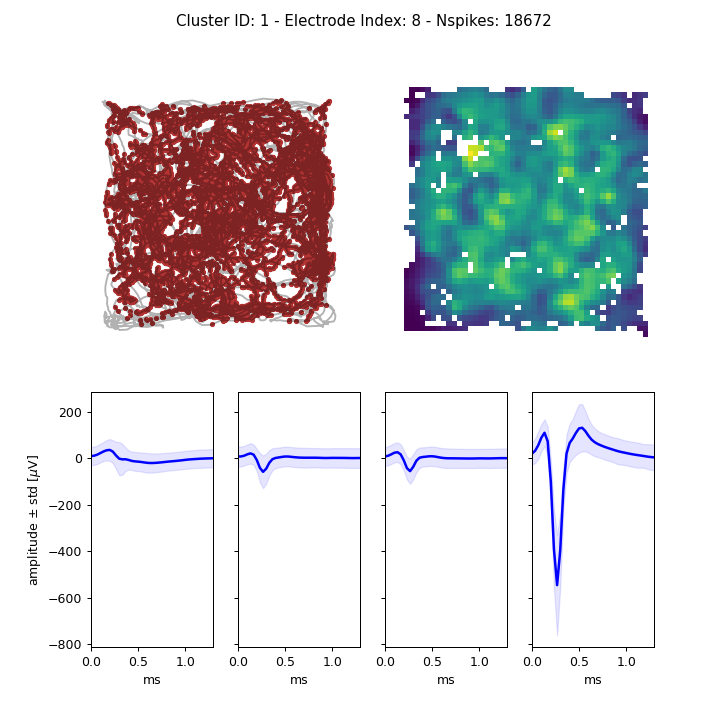

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


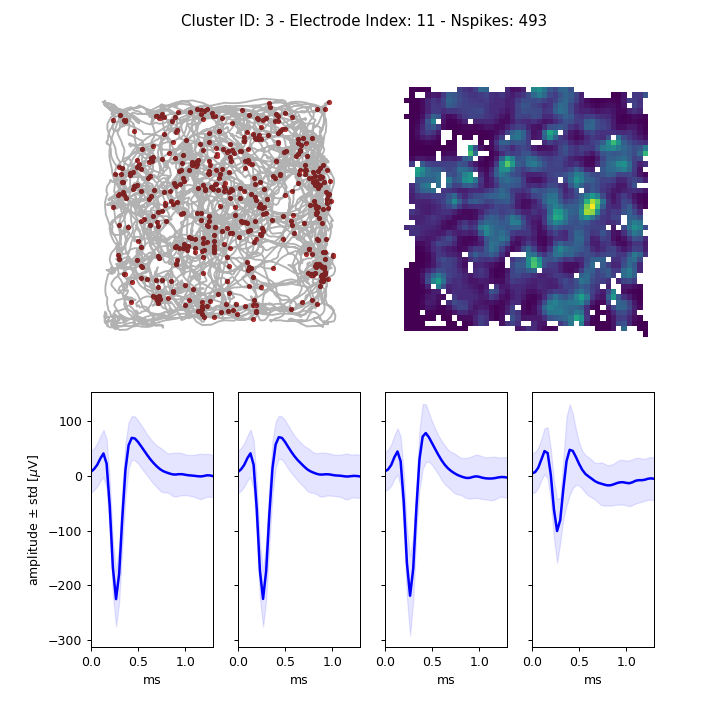

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


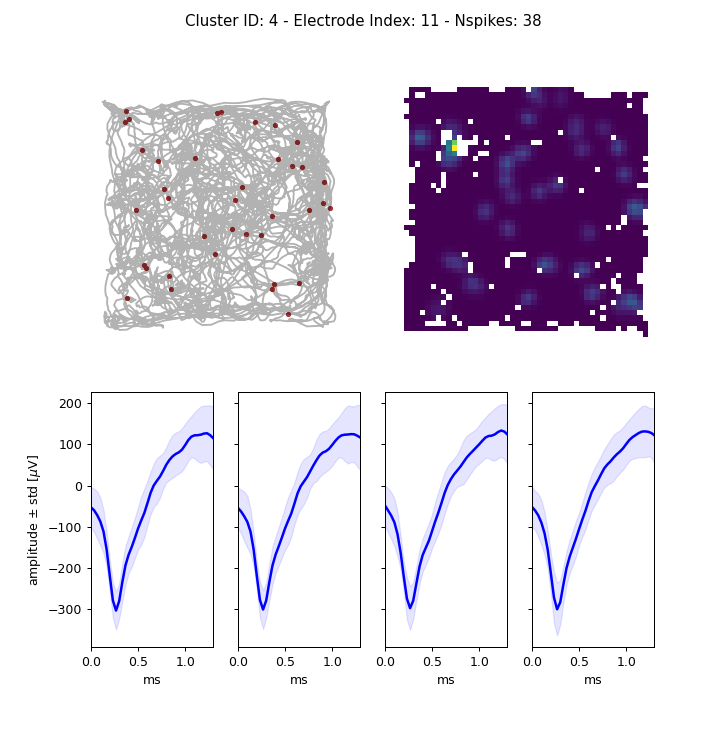

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


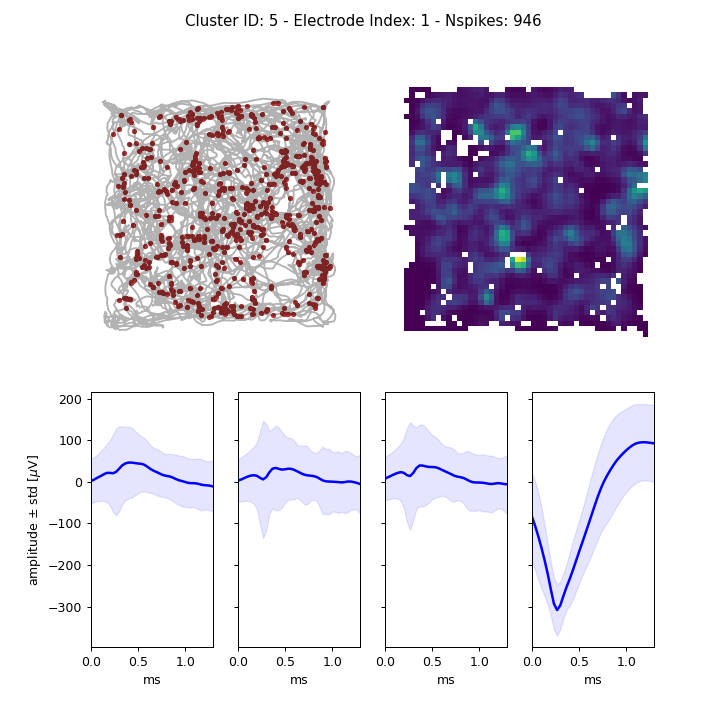

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


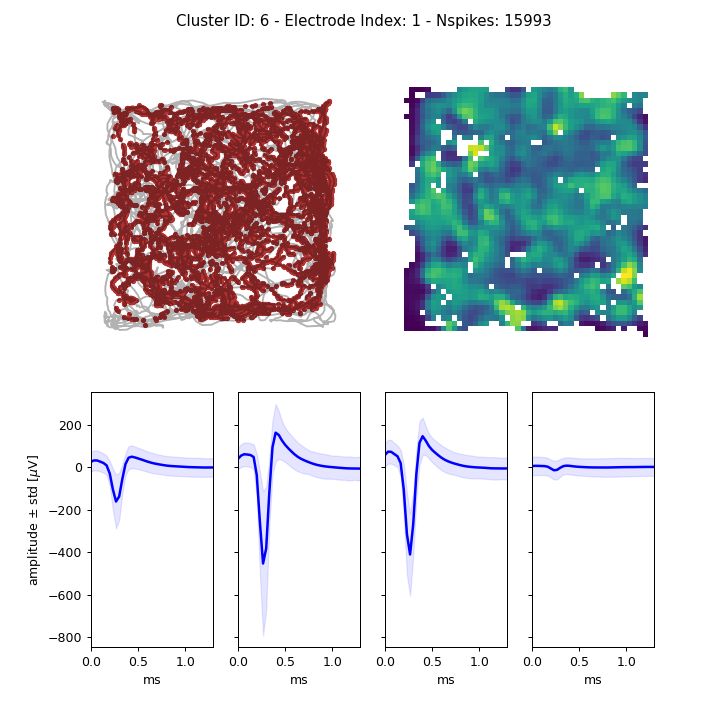

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [11]:
plot_generator = plot_summary(neo_sptrs, x,y,t)
for plot_i,cluster_id,channel_id in plot_generator:
    plot_i
plt.show()

# Save figure to file

In [12]:
def mkdir_p(mypath):
    '''
    Code directly copied from: https://stackoverflow.com/questions/11373610/save-matplotlib-file-to-a-directory
    
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [15]:
plt.ioff() # turn of plotting unless plt.show() is called

# Choose path to where to save plot. Also creates necessary folders should they not already exist.
output_path = './plots'
mkdir_p(output_path)
save_str = os.path.join(output_path, action_name)

# get the plot generator again
plot_generator = plot_summary(neo_sptrs, x, y, t)

figures_to_save_cluster_ids = [1,3] # choose which figures you want to save (with respect to CLUSTER ID)
for plot_i,cluster_id,channel_id in plot_generator:
    if cluster_id in figures_to_save_cluster_ids:
        # Saves the figure to file
        tmp_str = save_str+'_cl{}-ch{}.pdf'.format(cluster_id, channel_id)
        plot_i.savefig(tmp_str)
        print("FIGURE SUCCESSFULLY SAVED TO: '{}'".format(tmp_str))
        

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


FIGURE SUCCESSFULLY SAVED TO: './plots\012-190321-1_cl1-ch8.pdf'


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


FIGURE SUCCESSFULLY SAVED TO: './plots\012-190321-1_cl3-ch11.pdf'


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
